In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qubit_zz_coupling.core import setup_operators, solve_t1, solve_t2, make_population, plot_t1, plot_t2, fq_shift
from qutip import basis, tensor
from qtt.algorithms.functions import gauss_ramsey, fit_gauss_ramsey, plot_gauss_ramsey_fit

from qutip import basis, tensor, sigmaz, sigmax, sigmaz, sigmam, sigmap, mesolve, identity, Qobj, destroy, qeye
from tqdm import tqdm


In [2]:
sm_q1 = tensor(sigmam(), identity(2), identity(2))
n1 = sm_q1.dag()*sm_q1

sm_q2 = tensor(identity(2), sigmam(), identity(2))
n2 = sm_q2.dag()*sm_q2

In [3]:
def min_max(v):
    id_min = np.argmin(v)
    id_max = np.argmax(v)

    min_value = v[id_min]
    max_value = v[id_max]
    print(f'min: {min_value} max:{max_value}')
    return min_value, max_value

In [4]:
# Define system parameters
SYSTEM_PARAMS_base = {
    "f_q1": 3.2,  # GHz, Qubit 1 frequency (3.2)
    "f_q2": 3.35,  # GHz, Qubit 2 frequency
    "f_tls": 3.2,  # GHz, TLS frequency (resonant with Qubit 1)
    "T1": {"q1": 200, "q2": 250, "tls": 500},  # Relaxation rates
    "T2": {"q1": 150, "q2": 180, "tls": 300},  # Dephasing rates
    "J_zz": 0.00, # Jzz coupling
    "J_tls": 0.5,  # GHz, Coupling strength between Qubit 1 and TLS
    "time_points": np.linspace(0, 300, 105)  # Time points in μs
}

SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

# get times
tlist = SYSTEM_PARAMS["time_points"]

# T1 measurement for Qubit 1 

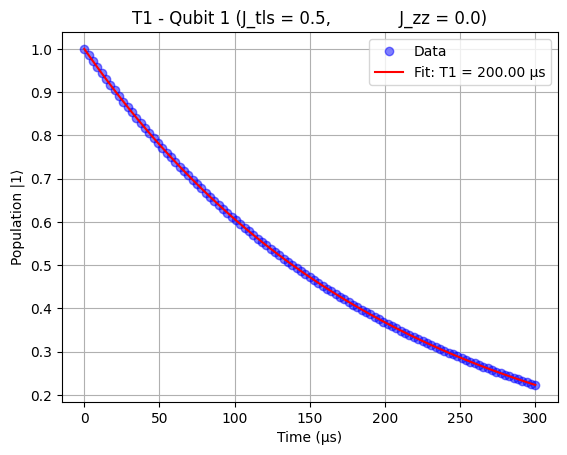

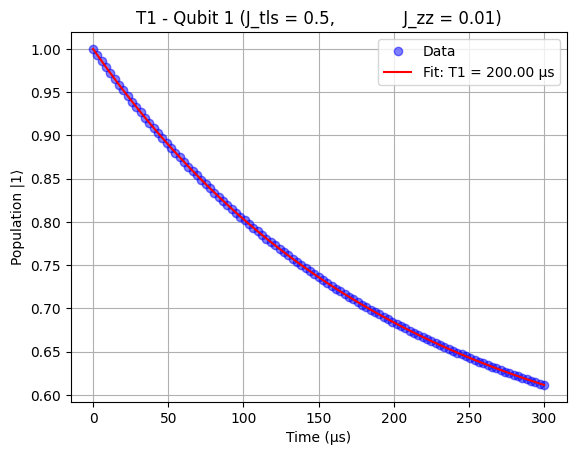

In [5]:
# T1 measurement for Qubit 1 
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

# no jzz
psi0 = tensor(basis(2,0), basis(2,1), basis(2,1))  # |0⟩|1⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q1], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q1], "Qubit 1", SYSTEM_PARAMS)

# with coupling
SYSTEM_PARAMS["J_zz"] = 0.01

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)
psi0 = tensor(basis(2,0), basis(2,1), basis(2,1))  # |0⟩|1⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q1], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [n1], "Qubit 1", SYSTEM_PARAMS)
plt.show() 


# T1 measurement for Qubit 2 

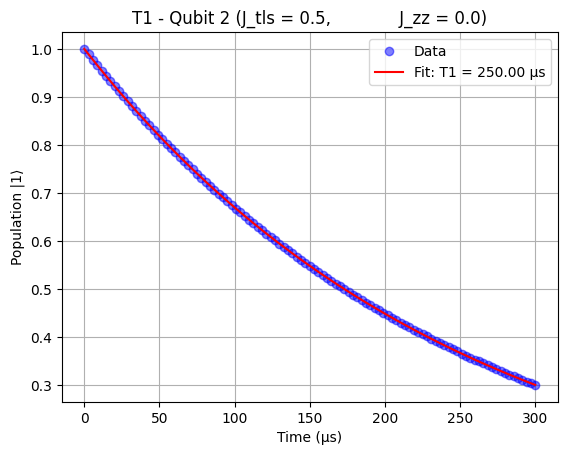

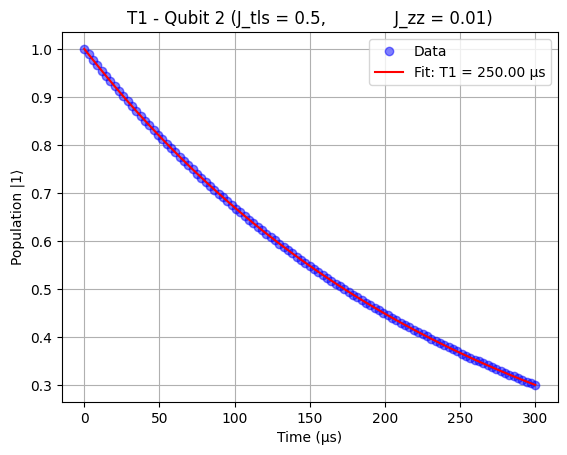

In [6]:
# T1 measurement for Qubit 2 
# no Jzz
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy()

SYSTEM_PARAMS["J_zz"] = 0.00
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), basis(2,0), basis(2,1))  # |1⟩|0⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q2], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q2], "Qubit 2", SYSTEM_PARAMS)

# with Coupling
SYSTEM_PARAMS["J_zz"] = 0.01
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)
psi0 = tensor(basis(2,1), basis(2,0), basis(2,1))  # |1⟩|0⟩|1⟩

solve_t1(H, psi0, tlist, c_ops, [sz_q2], ret_pop=False)
plot_t1(H, psi0, tlist, c_ops, [sz_q2], "Qubit 2", SYSTEM_PARAMS)

plt.show()

# T2 measurement for Qubit 1 

c:\Users\jayamao\.conda\envs\qiskit\lib\site-packages\qubit_zz_coupling\utils.py:68: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-t/T2_star) * np.cos((2*np.pi*f*t) + phi) + C


[5.00018881e-01 1.07769025e+02 3.14667224e+00 2.31891118e-05
 4.99999790e-01]
[5.00018868e-01 1.07750049e+02 3.18667232e+00 2.36107638e-05
 4.99999798e-01]


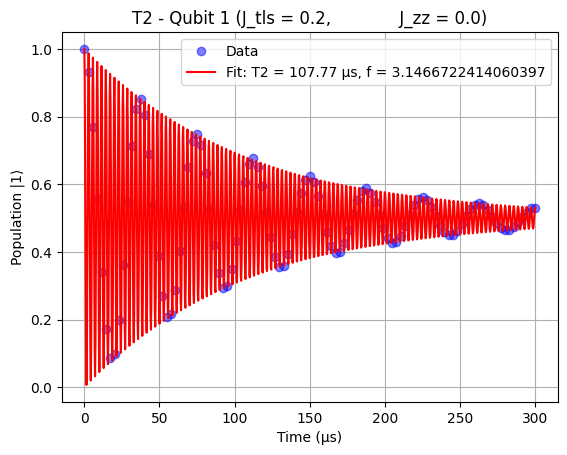

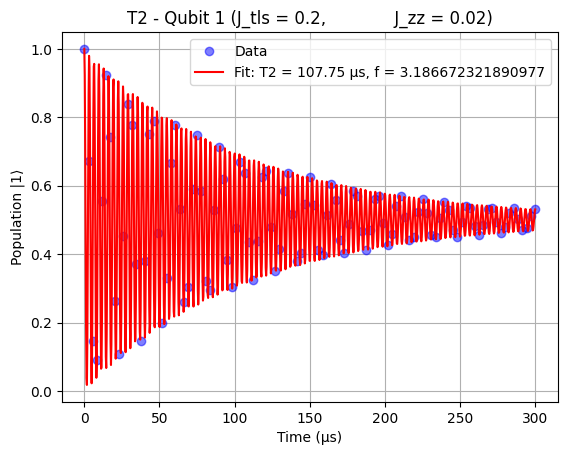

In [5]:
# T2 measurement for Qubit 1 
SYSTEM_PARAMS["J_zz"] = 0.0  #0.0
SYSTEM_PARAMS["J_tls"] = 0.2 #0.05
SYSTEM_PARAMS["ver1"] = False
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor((basis(2,1) + basis(2,0)).unit(), basis(2,1), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, SYSTEM_PARAMS["T2"]["q1"], SYSTEM_PARAMS["f_q1"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
plot_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, "Qubit 1", SYSTEM_PARAMS,  use_fit_gauss=False)

# with coupling
SYSTEM_PARAMS["J_zz"] = 0.02
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)
psi0 = tensor((basis(2,1) + basis(2,0)).unit(), basis(2,1), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, SYSTEM_PARAMS["T2"]["q1"], SYSTEM_PARAMS["f_q1"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, "Qubit 1", SYSTEM_PARAMS)

plt.show()

# T2 measurement for Qubit 2 

[5.00021580e-01 1.75968867e+02 3.35000625e+00 2.70204815e-05
 4.99999792e-01]
[5.00021587e-01 1.75921745e+02 3.39000632e+00 2.71894537e-05
 4.99999788e-01]


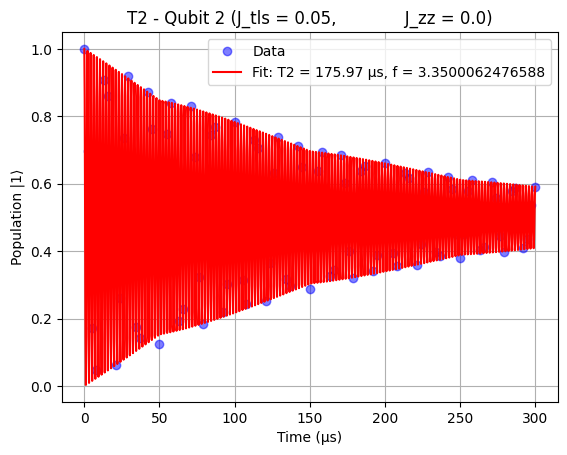

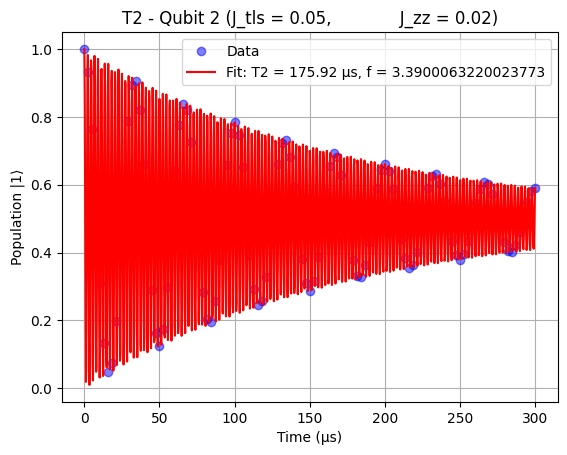

In [9]:
tlist = np.linspace(0, 300, 115)

# T2 measurement for Qubit 2 
SYSTEM_PARAMS["J_zz"] = 0.00
SYSTEM_PARAMS["J_tls"] = 0.05
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, SYSTEM_PARAMS["T2"]["q2"], SYSTEM_PARAMS["f_q2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)

# with coupling
SYSTEM_PARAMS["J_zz"] = 0.02
H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=SYSTEM_PARAMS)

psi0 = tensor(basis(2,1), (basis(2,1) + basis(2,0)).unit(), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, SYSTEM_PARAMS["T2"]["q2"], SYSTEM_PARAMS["f_q2"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False)
plot_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, "Qubit 2", SYSTEM_PARAMS)

plt.show()

# Scanning Jzz

# Scan Q1

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:52<00:00,  5.20s/it]


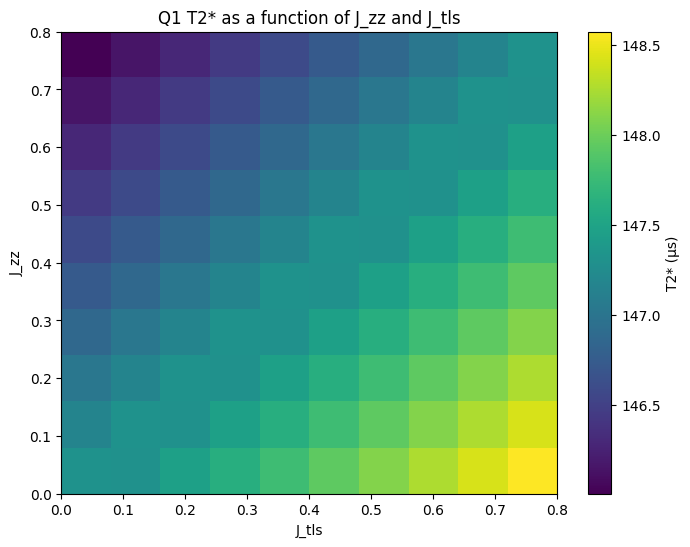

In [10]:
tlist = np.linspace(0, 300, 85)  # Time points in μs

SYSTEM_PARAMS["J_xx"] = 0.00

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.8, 10)
JTLS_vals = np.linspace(0.00, 0.8, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["J_zz"] = Jzz
        params["J_tls"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor( (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1),  basis(2, 1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, params["T2"]["q1"], params["f_q1"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for J_zz={Jzz}, J_tls={JTLS}")
            continue 
  
        #if fit_par[1] > 85:
        #    plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)
        #    fit_par[1] = 60

        #if do_print:
        #    plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)
        #    do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('J_tls')
plt.ylabel('J_zz')
plt.title('Q1 T2* as a function of J_zz and J_tls')
plt.show()

#print(T2_matrix)

# Scan Q2

100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


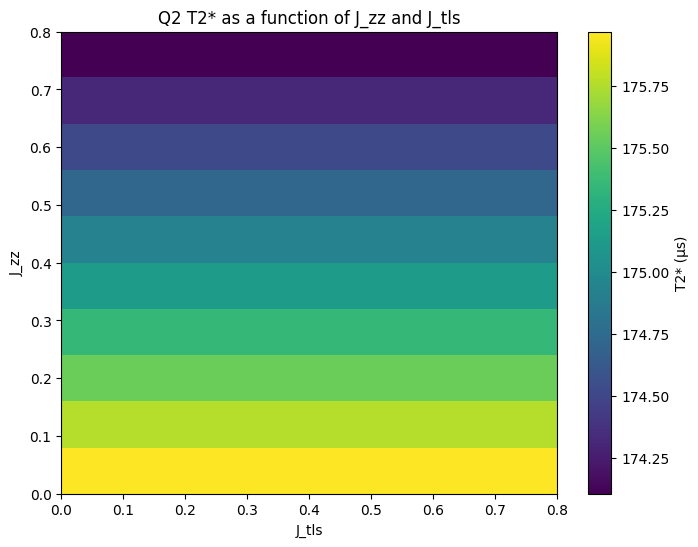

In [11]:

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.80, 10)
JTLS_vals = np.linspace(0.00, 0.80, 10)
T2_matrix = np.zeros((len(Jzz_vals), len(JTLS_vals)))

# Base system parameters (without Jzz and JTLS)
base_params = SYSTEM_PARAMS.copy()

tlist = base_params["time_points"]
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, JTLS in enumerate(JTLS_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["J_zz"] = Jzz
        params["J_tls"] = JTLS

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor(  basis(2, 1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |1⟩|+⟩|1⟩
        first_guess = [0.5, params["T2"]["q2"], params["f_q2"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            print(f"Error solving T2 for J_zz={Jzz}, J_tls={JTLS}")
            continue 
  
        #if fit_par[1] < 20:
        #    plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
        #    fit_par[1] = 75

        #if do_print:
        #    plot_t2(H, psi0, tlist, c_ops, [sx_q2], fit_par, "Qubit 2", params)
        #    do_print = False

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[JTLS_vals[0], JTLS_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('J_tls')
plt.ylabel('J_zz')
plt.title('Q2 T2* as a function of J_zz and J_tls')
plt.show()

#print(T2_matrix)

# Scan Jzz and Jxx for Qubit 1 (OBSOLETE)

 53%|█████▎    | 8/15 [02:22<02:07, 18.20s/it]

Error solving T2 for Jzz=0.4571428571428572, Jxx=0.3571428571428571


 60%|██████    | 9/15 [02:41<01:50, 18.41s/it]

[5.25319001e-01 9.68183960e+01 8.06806547e-02 1.42982093e-01
 5.00233166e-01]


 93%|█████████▎| 14/15 [04:19<00:19, 19.47s/it]

Error solving T2 for Jzz=0.8, Jxx=0.46428571428571425


100%|██████████| 15/15 [04:42<00:00, 18.81s/it]


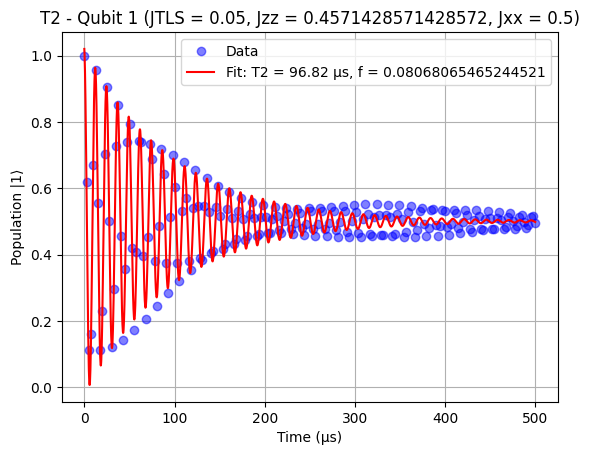

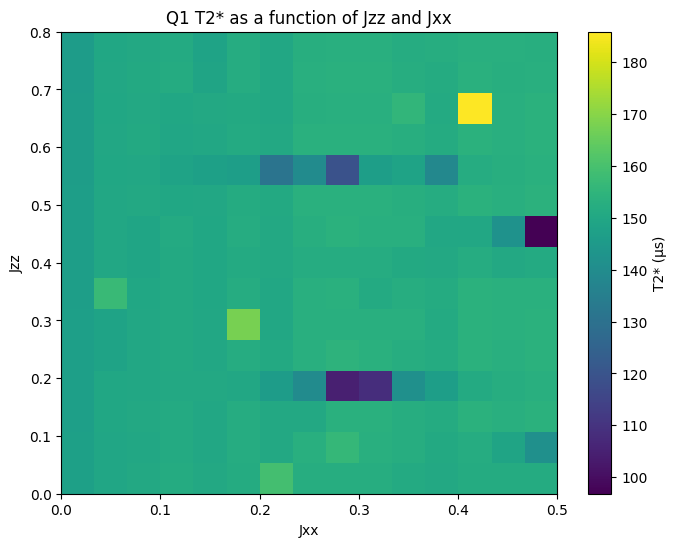

In [6]:
fails = []
check = []
last = 0.0

# Define parameter ranges
Jzz_vals = np.linspace(0.00, 0.8, 15)
Jxx_vals = np.linspace(0.00, 0.5, 15)
T2_matrix = np.zeros((len(Jzz_vals), len(Jxx_vals)))

# Base system parameters (without Jzz and Jxx)
base_params = SYSTEM_PARAMS_base.copy()

tlist = np.linspace(0,500,200)
do_print = True
for i, Jzz in enumerate(tqdm(Jzz_vals)):
    for j, Jxx in enumerate(Jxx_vals):

        # Update parameters for this scan
        params = base_params.copy()
        params["Jzz"] = Jzz
        params["Jxx"] = Jxx

        # Setup system
        H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
        psi0 = tensor( (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1), basis(2,1))  # |+⟩|1⟩|1⟩
        first_guess = [0.5, 1.0 / params["dephasing"]["q1"], params["fq1"], 0.0, 0.5]

        # Solve T2 and store the fitted T2 value
        try:
            fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        except:
            fails.append(params)
            print(f"Error solving T2 for Jzz={Jzz}, Jxx={Jxx}")
            fit_par[1] = last

        if fit_par[1] < 100:
            check.append(params)
            plot_t2(H, psi0, tlist, c_ops, [sx_q1], fit_par, "Qubit 1", params)

        T2_matrix[i, j] = fit_par[1]  # T2* is the second parameter
        last = fit_par[1]
            

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(T2_matrix, origin='lower', aspect='auto',
           extent=[Jxx_vals[0], Jxx_vals[-1], Jzz_vals[0], Jzz_vals[-1]],
           cmap='viridis')
plt.colorbar(label='T2* (μs)')
plt.xlabel('Jxx')
plt.ylabel('Jzz')
plt.title('Q1 T2* as a function of Jzz and Jxx')
plt.show()

#print(T2_matrix)

[3.44308780e-01 1.49821678e+02 3.23755964e-02 4.26221020e-02
 5.01056640e-01]


<Axes: title={'center': 'T2 - Qubit 1 (JTLS = 0.05, Jzz = 0.4571428571428572, Jxx = 0.5)'}, xlabel='Time (μs)', ylabel='Population |1⟩'>

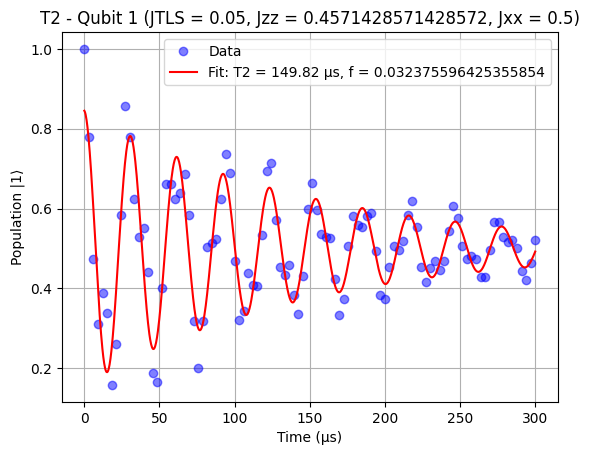

In [11]:
tlist = np.linspace(0, 300, 100)

H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=check[0])

psi0 = tensor((basis(2,1) + basis(2,0)).unit(), basis(2,1), basis(2,1))  # |+⟩|1⟩|1⟩

first_guess = [0.5, 1.0 / SYSTEM_PARAMS["dephasing"]["q1"], SYSTEM_PARAMS["fq1"], 0.0, 0.5]

solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
plot_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, "Qubit 1", check[0], use_fit_gauss=True, no_fit=False)

# Q1 (Q5)  T2 Freq scan

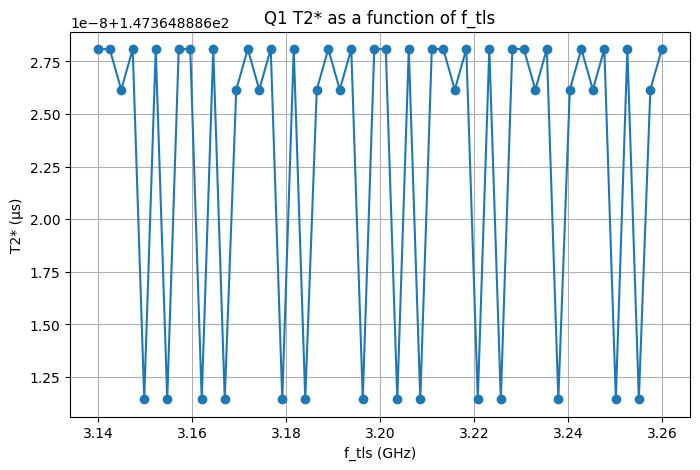

In [14]:
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy() # reset everything

# Define parameter ranges
SYSTEM_PARAMS["J_zz"] = 0.02
SYSTEM_PARAMS["J_tls"] = 0.05

shift = 0.06 # in Ghz
fTLS_vals = np.linspace(3.2-shift, 3.2+shift, 50)  # Example: scan fTLS from 3.0 to 3.5 GHz
T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["f_tls"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2,1), basis(2, 1))  # |+⟩|1⟩|1⟩
    first_guess = [0.5, params["T2"]["q1"], params["f_q1"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for f_tls={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(fTLS_vals, T2_vec, marker='o')
plt.xlabel('f_tls (GHz)')
plt.ylabel('T2* (μs)')
plt.title('Q1 T2* as a function of f_tls')
plt.grid(True)
plt.show()

# Q2 T2 Freq Scan

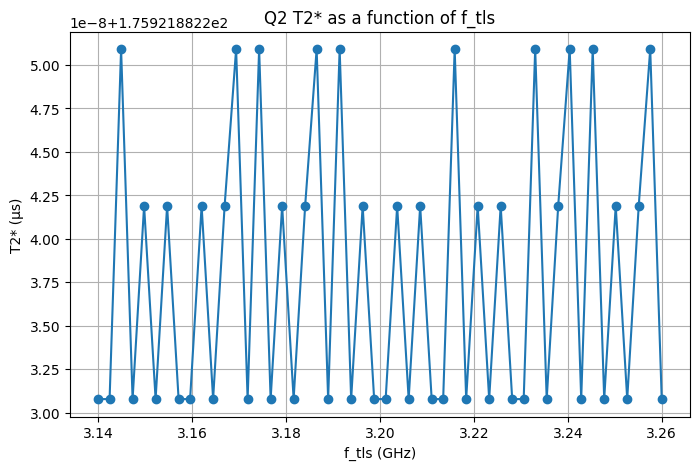

In [15]:
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy() # reset everything

# Define parameter ranges
SYSTEM_PARAMS["J_zz"] = 0.02
SYSTEM_PARAMS["J_tls"] = 0.05

shift = 0.06 # in Ghz
fTLS_vals = np.linspace(3.2-shift, 3.2+shift, 50)  # Example: scan fTLS from 3.0 to 3.5 GHz
T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["f_tls"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor(basis(2,1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |1⟩|+⟩|1⟩
    first_guess = [0.5, params["T2"]["q2"], params["f_q2"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for f_tls={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(fTLS_vals, T2_vec, marker='o')
plt.xlabel('f_tls (GHz)')
plt.ylabel('T2* (μs)')
plt.title('Q2 T2* as a function of f_tls')
plt.grid(True)
plt.show()

# Over Time

c:\Users\jayamao\.conda\envs\qiskit\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


<Figure size 800x500 with 0 Axes>

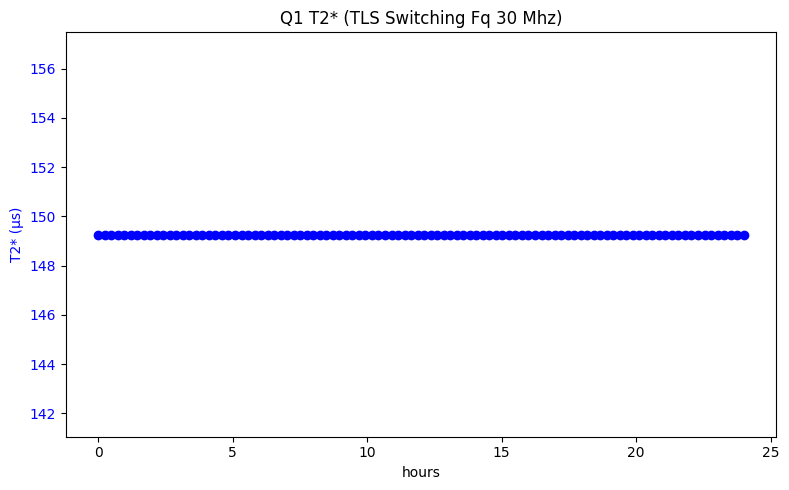

In [16]:
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy() # reset everything

# Define parameter ranges
SYSTEM_PARAMS["J_zz"] = 0.01
SYSTEM_PARAMS["J_tls"] = 0.05

# shift tls over time 24 hrs
sample = np.linspace(0,24,100)
fTLS_vals = fq_shift(sample, 3.215, 0.015, 6, phi=0, jump=True, noise_level=0.00)

T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["f_tls"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor((basis(2, 0) + basis(2, 1)).unit(), basis(2,1), basis(2, 1))  # |+⟩|1⟩|1⟩
    #psi0 = tensor(basis(2, 0), basis(2,1), basis(2, 0))  # |+⟩|1⟩|1⟩
    
    first_guess = [0.5, params["T2"]["q1"], params["f_q1"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q1], first_guess, ret_pop=False, use_fit_gauss=True)
        
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for f_tls={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
fig, ax1 = plt.subplots(figsize=(8, 5))

# First plot (T2_vec)
ax1.plot(sample, T2_vec, marker='o', color='b', label='T2*')
ax1.set_xlabel('hours')
ax1.set_ylabel('T2* (μs)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Second plot (sample) on a different y-axis
if False:
    ax2 = ax1.twinx()
    ax2.plot(sample, fTLS_vals, marker='o', color='r', label='sample')
    ax2.set_ylabel('Sample', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

plt.title('Q1 T2* (TLS Switching Fq 30 Mhz)')
fig.tight_layout()
plt.show()

#  Q2

<Figure size 800x500 with 0 Axes>

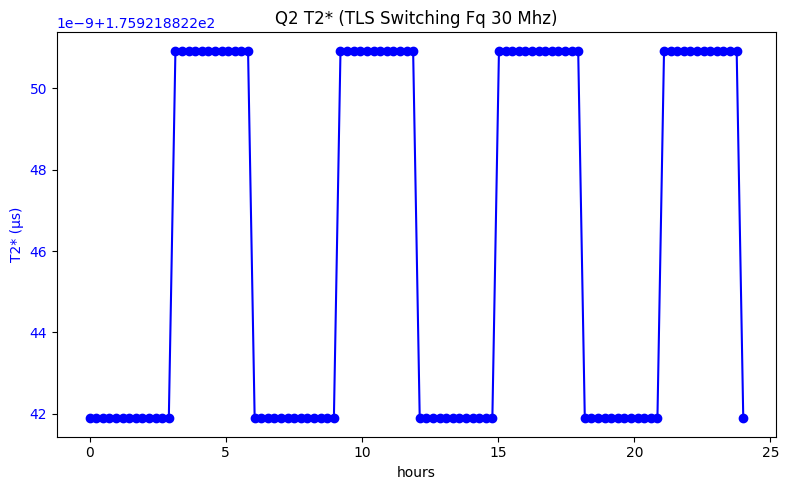

In [12]:
SYSTEM_PARAMS = SYSTEM_PARAMS_base.copy() # reset everything

# Define parameter ranges
SYSTEM_PARAMS["Jzz"] = 0.02
SYSTEM_PARAMS["Jxt"] = 0.05
SYSTEM_PARAMS["JTLS"] = 0.05

# shift tls over time 24 hrs
sample = np.linspace(0,24,100)
fTLS_vals = fq_shift(sample, 3.215, 0.015, 6, phi=0, jump=True, noise_level=0.00)

T2_vec = np.zeros(len(fTLS_vals))

# Base system parameters (without fTLS)
base_params = SYSTEM_PARAMS.copy()
tlist = base_params["time_points"]

for k, fTLS in enumerate(fTLS_vals):
    # Update parameters for this scan
    params = base_params.copy()
    params["fTLS"] = fTLS

    # Setup system
    H, c_ops, sz_q1, sz_q2, sx_q1, sx_q2 = setup_operators(system_params=params)
    psi0 = tensor(basis(2,1), (basis(2, 0) + basis(2, 1)).unit(), basis(2, 1))  # |1⟩|+⟩|1⟩
    #psi0 = tensor(basis(2, 0), basis(2,1), basis(2, 0))  # |+⟩|1⟩|1⟩
    
    first_guess = [0.5, 1.0 / params["dephasing"]["q2"], params["fq2"], 0.0, 0.5]

    # Solve T2 and store the fitted T2 value
    try:
        fit_par = solve_t2(H, psi0, tlist, c_ops, [sx_q2], first_guess, ret_pop=False, use_fit_gauss=True)
        
        T2_vec[k] = fit_par[1]  # T2* is the second parameter
    except Exception as e:
        print(f"Error solving T2 for fTLS={fTLS}: {e}")
        T2_vec[k] = np.nan

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
fig, ax1 = plt.subplots(figsize=(8, 5))

# First plot (T2_vec)
ax1.plot(sample, T2_vec, marker='o', color='b', label='T2*')
ax1.set_xlabel('hours')
ax1.set_ylabel('T2* (μs)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Second plot (sample) on a different y-axis
if False:
    ax2 = ax1.twinx()
    ax2.plot(sample, fTLS_vals, marker='o', color='r', label='sample')
    ax2.set_ylabel('Sample', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

plt.title('Q2 T2* (TLS Switching Fq 30 Mhz)')
fig.tight_layout()
plt.show()

In [28]:
min, max = max_min(T2_vec)
print(max-min)

min: 147.99981620763884 max:147.99981623510226
2.7463414653539076e-08


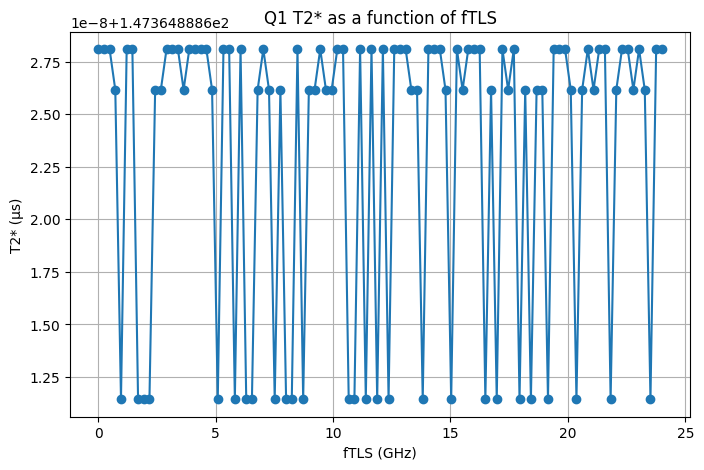

In [39]:
# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(sample, T2_vec, marker='o')
plt.xlabel('fTLS (GHz)')
plt.ylabel('T2* (μs)')
plt.title('Q1 T2* as a function of fTLS')
plt.grid(True)
plt.show()

<Figure size 800x500 with 0 Axes>

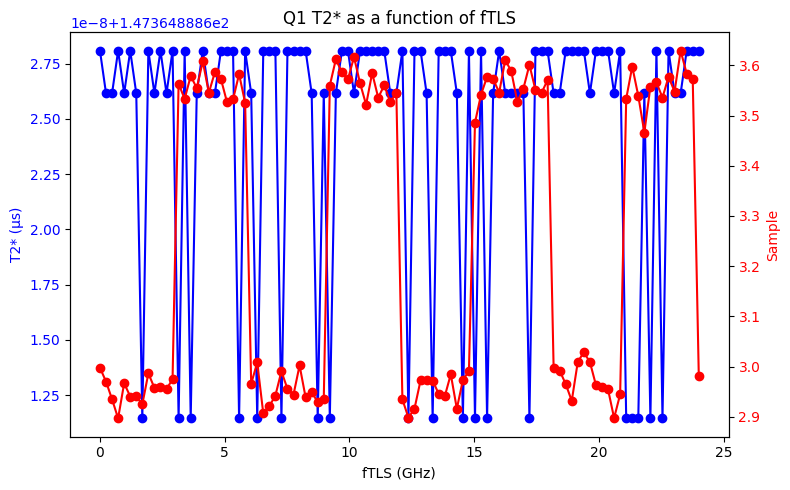

In [13]:
plt.figure(figsize=(8, 5))
fig, ax1 = plt.subplots(figsize=(8, 5))

# First plot (T2_vec)
ax1.plot(sample, T2_vec, marker='o', color='b', label='T2*')
ax1.set_xlabel('fTLS (GHz)')
ax1.set_ylabel('T2* (μs)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Second plot (sample) on a different y-axis
ax2 = ax1.twinx()
ax2.plot(sample, fTLS_vals, marker='o', color='r', label='sample')
ax2.set_ylabel('Sample', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Q1 T2* as a function of fTLS')
fig.tight_layout()
plt.show()

In [19]:
idx = np.argmin(T2_vec)
min_value = T2_vec[idx]
print(fTLS_vals[idx])

2.92462366053374


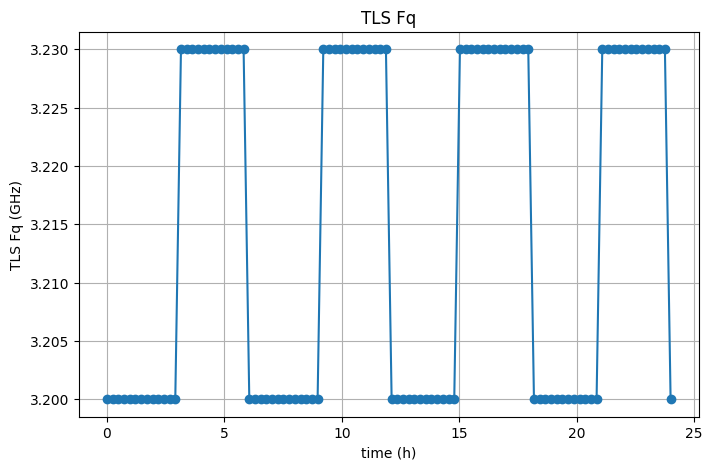

In [26]:
tlist = np.linspace(0,24,100)
p = fq_shift(tlist, 3.215, 0.015, 6, phi=0, jump=True, noise_level=0.0)
#p = fq_shift(tlist, 2.9, 0.3, 6, phi=0, jump=True, noise_level=0.00)

# Plot T2* vs fTLS
plt.figure(figsize=(8, 5))
plt.plot(tlist, p, marker='o')
plt.xlabel('time (h)')
plt.ylabel('TLS Fq (GHz)')
plt.title('TLS Fq')
plt.grid(True)
plt.show()

In [29]:
np.random.normal(loc=0, scale=.05, size=10)

array([ 0.04128698, -0.01848415,  0.01743635,  0.03984335,  0.00516831,
       -0.02036967, -0.06721619, -0.02715339,  0.00902517,  0.00872817])

In [29]:
np.pi * 2 * 0.1

0.6283185307179586